# 🎯 Complete Inventory Optimization

This notebook performs comprehensive inventory optimization using multiple techniques:
- **EOQ**: Economic Order Quantity
- **Safety Stock**: Buffer inventory calculation
- **Reorder Point**: When to replenish
- **Cost Analysis**: Holding vs ordering costs
- **Service Level Optimization**: Trade-off analysis

## Objectives
1. Calculate optimal inventory parameters
2. Analyze cost implications
3. Generate actionable recommendations
4. Perform sensitivity analysis
5. Create what-if scenarios

In [4]:
# Setup
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from scipy import stats

# Import project modules
from src.inventory import EOQCalculator, SafetyStockCalculator, ReorderPointCalculator
from src.utils import load_config

# Configure display
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Setup complete!")

✅ Setup complete!


## 1. Load Data and Configuration

In [7]:
# Load configuration
config = load_config(project_root / 'config/config.yaml')

# Check if processed data exists, if not generate it
processed_file = project_root / 'data/processed/abc_xyz_classified_ca1.csv'

if not processed_file.exists():
    print("⚠️  Processed data not found. Generating from raw M5 data...")
    
    # Load raw M5 data from project-001
    m5_data_path = project_root.parent / 'project-001-demand-forecasting-system/data/raw'
    
    # Load data files directly
    calendar = pd.read_csv(m5_data_path / 'calendar.csv')
    sales_train = pd.read_csv(m5_data_path / 'sales_train_evaluation.csv')
    sell_prices = pd.read_csv(m5_data_path / 'sell_prices.csv')
    
    # Filter for CA_1 store
    ca1_cols = [col for col in sales_train.columns if col.startswith('d_')]
    ca1_sales = sales_train[sales_train['store_id'] == 'CA_1'][['item_id', 'dept_id', 'cat_id'] + ca1_cols].copy()
    
    print(f"Processing {len(ca1_sales)} items from CA_1 store...")
    
    # Calculate demand statistics for each item
    demand_stats = []
    for idx, row in ca1_sales.iterrows():
        item_id = row['item_id']
        dept_id = row['dept_id']
        cat_id = row['cat_id']
        
        # Sales data
        sales = row[ca1_cols].values.astype(float)
        
        # Skip if all sales are zero or NaN
        if np.sum(sales) == 0 or len(sales) == 0:
            continue
        
        # Calculate statistics
        stats = {
            'item_id': item_id,
            'store_id': 'CA_1',
            'dept_id': dept_id,
            'cat_id': cat_id,
            'sales_sum': float(np.sum(sales)),
            'sales_mean': float(np.mean(sales)),
            'sales_std': float(np.std(sales)) if len(sales) > 1 else 0.0,
            'sales_min': float(np.min(sales)),
            'sales_max': float(np.max(sales)),
            'demand_cv': float(np.std(sales) / np.mean(sales)) if np.mean(sales) > 0 and len(sales) > 1 else 0.0
        }
        demand_stats.append(stats)
    
    demand_stats = pd.DataFrame(demand_stats)
    print(f"Calculated statistics for {len(demand_stats)} items")
    
    # Merge with prices
    price_stats = sell_prices[sell_prices['store_id'] == 'CA_1'].groupby('item_id').agg({
        'sell_price': ['mean', 'std', 'min', 'max']
    }).reset_index()
    price_stats.columns = ['item_id', 'avg_price', 'price_std', 'price_min', 'price_max']
    
    demand_stats = demand_stats.merge(price_stats, on='item_id', how='left')
    
    # Fill NaN prices with median
    demand_stats['avg_price'].fillna(demand_stats['avg_price'].median(), inplace=True)
    
    # Calculate revenue
    demand_stats['revenue_sum'] = demand_stats['sales_sum'] * demand_stats['avg_price']
    
    # Perform ABC-XYZ classification
    from src.inventory import ABCAnalyzer
    abc_analyzer = ABCAnalyzer(
        abc_thresholds=config['inventory']['abc_thresholds'],
        xyz_thresholds=config['inventory']['xyz_thresholds']
    )
    
    classified = abc_analyzer.perform_combined_analysis(
        demand_stats,
        value_col='revenue_sum',
        cv_col='demand_cv'
    )
    
    # Save for future use
    classified.to_csv(processed_file, index=False)
    print(f"✅ Generated and saved processed data to {processed_file}")
else:
    # Load existing processed data
    classified = pd.read_csv(processed_file)
    print(f"✅ Loaded existing processed data from {processed_file}")

print(f"\nLoaded {len(classified)} items")
print(f"ABC-XYZ classes: {sorted(classified['abc_xyz_class'].unique())}")
print(f"\nConfiguration:")
print(f"  Lead time: {config['inventory']['lead_time']['default']} days")
print(f"  Service levels: {config['inventory']['service_levels']}")

classified.head()

⚠️  Processed data not found. Generating from raw M5 data...
Processing 3049 items from CA_1 store...
Processing 3049 items from CA_1 store...
Calculated statistics for 3049 items
✅ Generated and saved processed data to /Users/godsonkurishinkal/Projects/data-science-portfolio/project-002-inventory-optimization-engine/data/processed/abc_xyz_classified_ca1.csv

Loaded 3049 items
ABC-XYZ classes: ['AX', 'AY', 'AZ', 'BY', 'BZ', 'CZ']

Configuration:
  Lead time: 7 days
  Service levels: {'high_value': 0.99, 'medium_value': 0.95, 'low_value': 0.9}
Calculated statistics for 3049 items
✅ Generated and saved processed data to /Users/godsonkurishinkal/Projects/data-science-portfolio/project-002-inventory-optimization-engine/data/processed/abc_xyz_classified_ca1.csv

Loaded 3049 items
ABC-XYZ classes: ['AX', 'AY', 'AZ', 'BY', 'BZ', 'CZ']

Configuration:
  Lead time: 7 days
  Service levels: {'high_value': 0.99, 'medium_value': 0.95, 'low_value': 0.9}


,item_id,store_id,dept_id,cat_id,sales_sum,sales_mean,sales_std,sales_min,sales_max,demand_cv,avg_price,price_std,price_min,price_max,revenue_sum,cumulative_value,cumulative_pct,abc_class,xyz_class,abc_xyz_class,priority_score
2344,FOODS_3_120,CA_1,FOODS_3,FOODS,63107.0,32.512622,33.410356,0.0,205.0,1.027612,4.980000,0.000000,4.98,4.98,314272.860000,314272.860000,0.013629,A,Z,AZ,3
2314,FOODS_3_090,CA_1,FOODS_3,FOODS,128855.0,66.385884,57.485343,0.0,599.0,0.865927,1.388546,0.130263,1.00,1.60,178921.107624,493193.967624,0.021387,A,Y,AY,2
2810,FOODS_3_586,CA_1,FOODS_3,FOODS,88846.0,45.773313,16.336087,0.0,133.0,0.356891,1.595957,0.072529,1.48,1.68,141794.435319,634988.402943,0.027536,A,X,AX,1
2426,FOODS_3_202,CA_1,FOODS_3,FOODS,31825.0,16.396188,10.151159,0.0,90.0,0.619117,4.326454,0.242330,3.98,4.68,137689.395390,772677.798333,0.033507,A,Y,AY,2
2811,FOODS_3_587,CA_1,FOODS_3,FOODS,52356.0,26.973725,21.326075,0.0,138.0,0.790624,2.557305,0.099012,2.28,2.68,133890.258723,906568.057057,0.039314,A,Y,AY,2


## 2. Economic Order Quantity (EOQ)

In [8]:
# Initialize EOQ calculator
eoq_calc = EOQCalculator(
    holding_cost_rate=config['inventory']['costs']['holding_cost_rate'],
    ordering_cost=config['inventory']['costs']['ordering_cost']
)

print(f"Holding cost rate: {config['inventory']['costs']['holding_cost_rate']*100}% per year")
print(f"Ordering cost: ${config['inventory']['costs']['ordering_cost']} per order")

Holding cost rate: 25.0% per year
Ordering cost: $100 per order


In [9]:
# Calculate EOQ for all items
eoq_results = eoq_calc.calculate_for_dataframe(
    classified,
    demand_col='sales_sum',
    price_col='avg_price'
)

print(f"EOQ calculated for {len(eoq_results)} items")
print(f"\nEOQ Statistics:")
print(f"  Mean: {eoq_results['eoq'].mean():.2f} units")
print(f"  Median: {eoq_results['eoq'].median():.2f} units")
print(f"  Std Dev: {eoq_results['eoq'].std():.2f} units")
print(f"  Range: {eoq_results['eoq'].min():.0f} - {eoq_results['eoq'].max():.0f} units")

eoq_results[['item_id', 'sales_sum', 'avg_price', 'eoq', 'orders_per_year', 
             'total_annual_cost']].head(15)

EOQ calculated for 3049 items

EOQ Statistics:
  Mean: 2732.54 units
  Median: 1777.00 units
  Std Dev: 3114.75 units
  Range: 103 - 31109 units


,item_id,sales_sum,avg_price,eoq,orders_per_year,total_annual_cost
2344,FOODS_3_120,63107.0,4.980000,11496,71.560911,4.111083e+06
2314,FOODS_3_090,128855.0,1.388546,31109,53.994959,2.343163e+06
2810,FOODS_3_586,88846.0,1.595957,24095,48.067553,1.858005e+06
2426,FOODS_3_202,31825.0,4.326454,8759,47.366650,1.804353e+06
2811,FOODS_3_587,52356.0,2.557305,14612,46.708607,1.754697e+06
2023,FOODS_2_197,41312.0,3.231773,11546,46.642408,1.749740e+06
2070,FOODS_2_244,20210.0,5.840355,6007,43.855613,1.547423e+06
2476,FOODS_3_252,76055.0,1.520426,22840,43.407911,1.516079e+06
1846,FOODS_2_019,35716.0,3.232057,10735,43.370389,1.513467e+06
228,HOBBIES_1_236,7962.0,11.807935,2652,39.139969,1.233378e+06


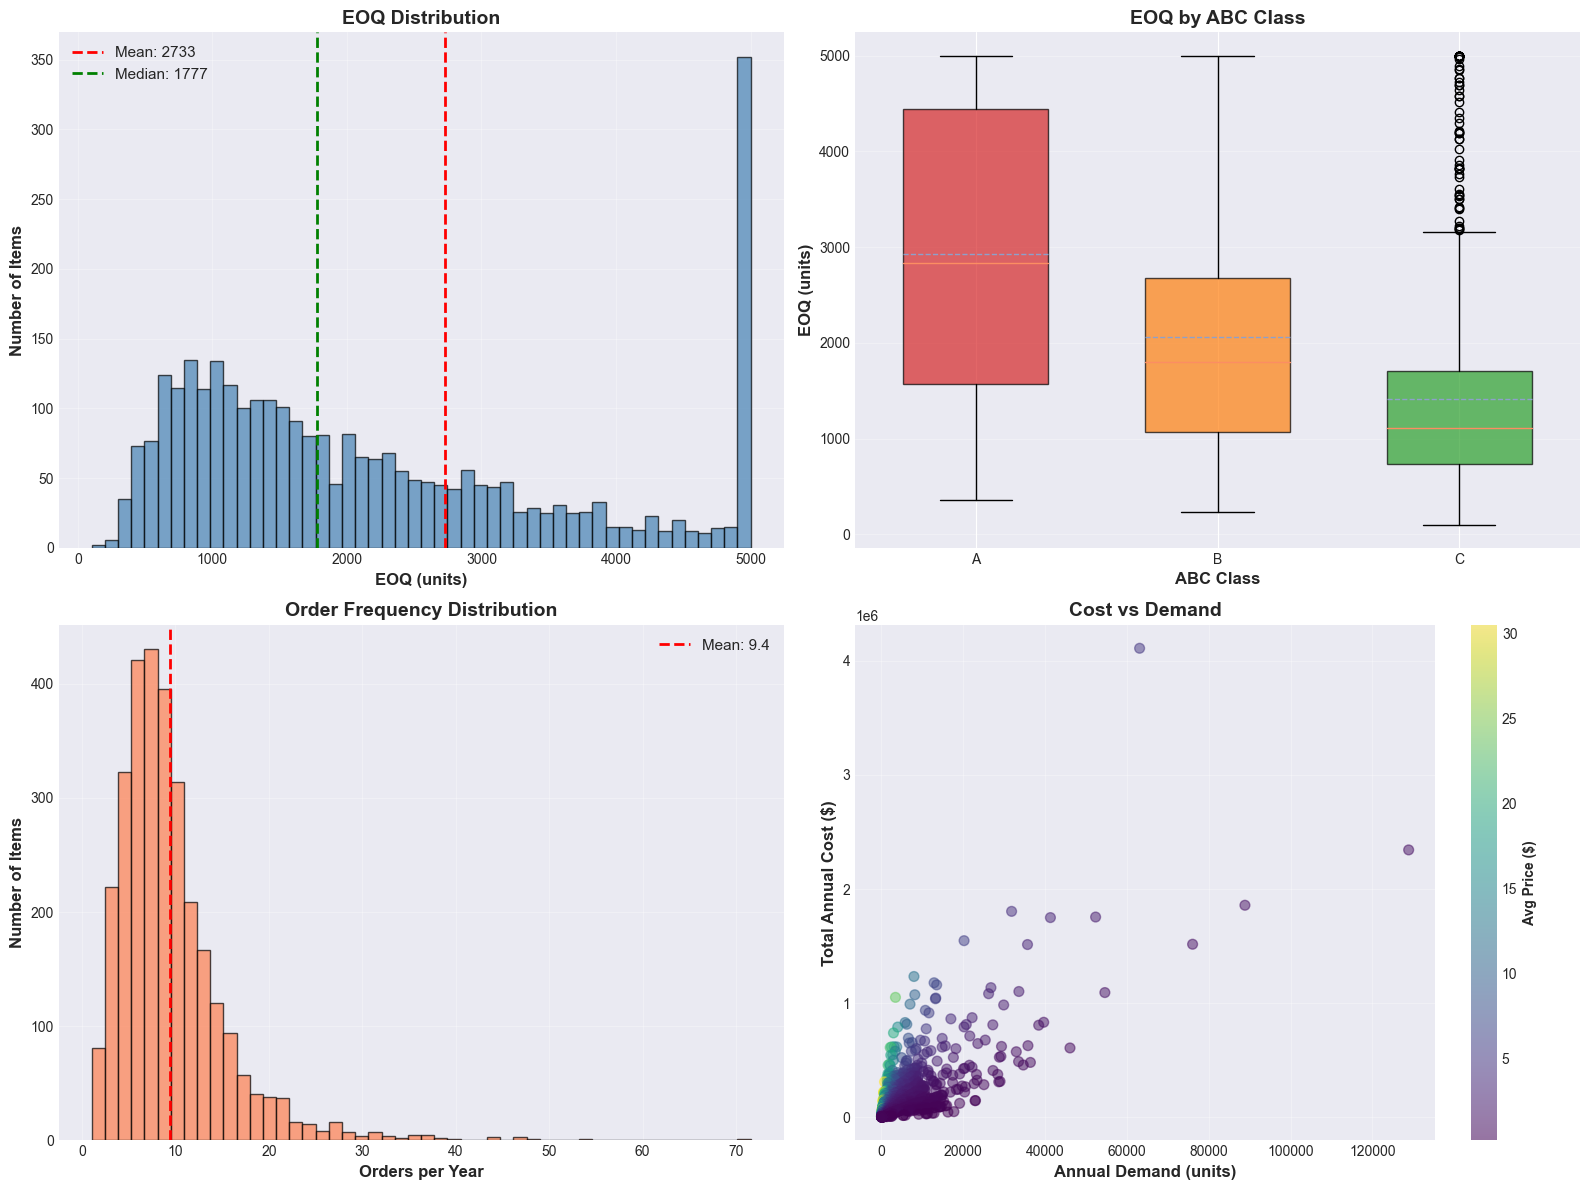

In [10]:
# EOQ distribution by ABC class
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# EOQ histogram
axes[0, 0].hist(eoq_results['eoq'].clip(0, 5000), bins=50, alpha=0.7, 
               color='steelblue', edgecolor='black')
axes[0, 0].axvline(x=eoq_results['eoq'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f"Mean: {eoq_results['eoq'].mean():.0f}")
axes[0, 0].axvline(x=eoq_results['eoq'].median(), color='green', linestyle='--', 
                   linewidth=2, label=f"Median: {eoq_results['eoq'].median():.0f}")
axes[0, 0].set_xlabel('EOQ (units)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Items', fontsize=12, fontweight='bold')
axes[0, 0].set_title('EOQ Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# EOQ by ABC class
abc_order = ['A', 'B', 'C']
colors_abc = {'A': '#d62728', 'B': '#ff7f0e', 'C': '#2ca02c'}
box_data_abc = [eoq_results[eoq_results['abc_class'] == cls]['eoq'].clip(0, 5000) 
                for cls in abc_order]
bp1 = axes[0, 1].boxplot(box_data_abc, labels=abc_order, patch_artist=True, 
                         widths=0.6, showmeans=True, meanline=True)
for patch, color in zip(bp1['boxes'], [colors_abc[c] for c in abc_order]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0, 1].set_xlabel('ABC Class', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('EOQ (units)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('EOQ by ABC Class', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Orders per year distribution
axes[1, 0].hist(eoq_results['orders_per_year'].clip(0, 100), bins=50, alpha=0.7,
               color='coral', edgecolor='black')
axes[1, 0].axvline(x=eoq_results['orders_per_year'].mean(), color='red', linestyle='--',
                  linewidth=2, label=f"Mean: {eoq_results['orders_per_year'].mean():.1f}")
axes[1, 0].set_xlabel('Orders per Year', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of Items', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Order Frequency Distribution', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Total cost vs demand
axes[1, 1].scatter(eoq_results['sales_sum'], eoq_results['total_annual_cost'], 
                  alpha=0.5, s=50, c=eoq_results['avg_price'], cmap='viridis')
axes[1, 1].set_xlabel('Annual Demand (units)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Total Annual Cost ($)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Cost vs Demand', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
cbar.set_label('Avg Price ($)', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Safety Stock Calculation

In [11]:
# Initialize safety stock calculator
# We'll create calculators for each service level
lead_time = config['inventory']['lead_time']['default']
service_levels = config['inventory']['service_levels']

print(f"Lead time: {lead_time} days")
print(f"Service levels by class:")
for cls, level in service_levels.items():
    print(f"  {cls}: {level*100}%")

Lead time: 7 days
Service levels by class:
  high_value: 99.0%
  medium_value: 95.0%
  low_value: 90.0%


In [12]:
# Calculate safety stock for each ABC class
from scipy import stats

# Map ABC classes to service levels
service_level_map = {
    'A': service_levels['high_value'],
    'B': service_levels['medium_value'],
    'C': service_levels['low_value']
}

eoq_results['service_level'] = eoq_results['abc_class'].map(service_level_map)
eoq_results['z_score'] = eoq_results['service_level'].apply(lambda sl: stats.norm.ppf(sl))

# Calculate safety stock: Z * σ_demand * √lead_time
eoq_results['safety_stock'] = (
    eoq_results['z_score'] * 
    eoq_results['sales_std'] * 
    np.sqrt(lead_time)
).round(0).astype(int)

safety_results = eoq_results.copy()

print(f"Safety stock calculated for {len(safety_results)} items")
print(f"\nSafety Stock Statistics:")
print(f"  Mean: {safety_results['safety_stock'].mean():.2f} units")
print(f"  Median: {safety_results['safety_stock'].median():.2f} units")
print(f"  Std Dev: {safety_results['safety_stock'].std():.2f} units")

print(f"\nBy ABC Class:")
for cls in ['A', 'B', 'C']:
    class_data = safety_results[safety_results['abc_class'] == cls]
    if len(class_data) > 0:
        print(f"  Class {cls}: Mean = {class_data['safety_stock'].mean():.2f} units, "
              f"Service Level = {class_data['service_level'].iloc[0]*100}%")

safety_results[['item_id', 'abc_class', 'sales_mean', 'sales_std', 
                'service_level', 'z_score', 'safety_stock']].head(15)

Safety stock calculated for 3049 items

Safety Stock Statistics:
  Mean: 9.07 units
  Median: 5.00 units
  Std Dev: 14.88 units

By ABC Class:
  Class A: Mean = 16.87 units, Service Level = 99.0%
  Class B: Mean = 5.36 units, Service Level = 95.0%
  Class C: Mean = 2.39 units, Service Level = 90.0%


,item_id,abc_class,sales_mean,sales_std,service_level,z_score,safety_stock
2344,FOODS_3_120,A,32.512622,33.410356,0.99,2.326348,206
2314,FOODS_3_090,A,66.385884,57.485343,0.99,2.326348,354
2810,FOODS_3_586,A,45.773313,16.336087,0.99,2.326348,101
2426,FOODS_3_202,A,16.396188,10.151159,0.99,2.326348,62
2811,FOODS_3_587,A,26.973725,21.326075,0.99,2.326348,131
2023,FOODS_2_197,A,21.283874,12.685199,0.99,2.326348,78
2070,FOODS_2_244,A,10.412159,6.894669,0.99,2.326348,42
2476,FOODS_3_252,A,39.183411,18.673152,0.99,2.326348,115
1846,FOODS_2_019,A,18.400824,10.937416,0.99,2.326348,67
228,HOBBIES_1_236,A,4.102009,4.358237,0.99,2.326348,27


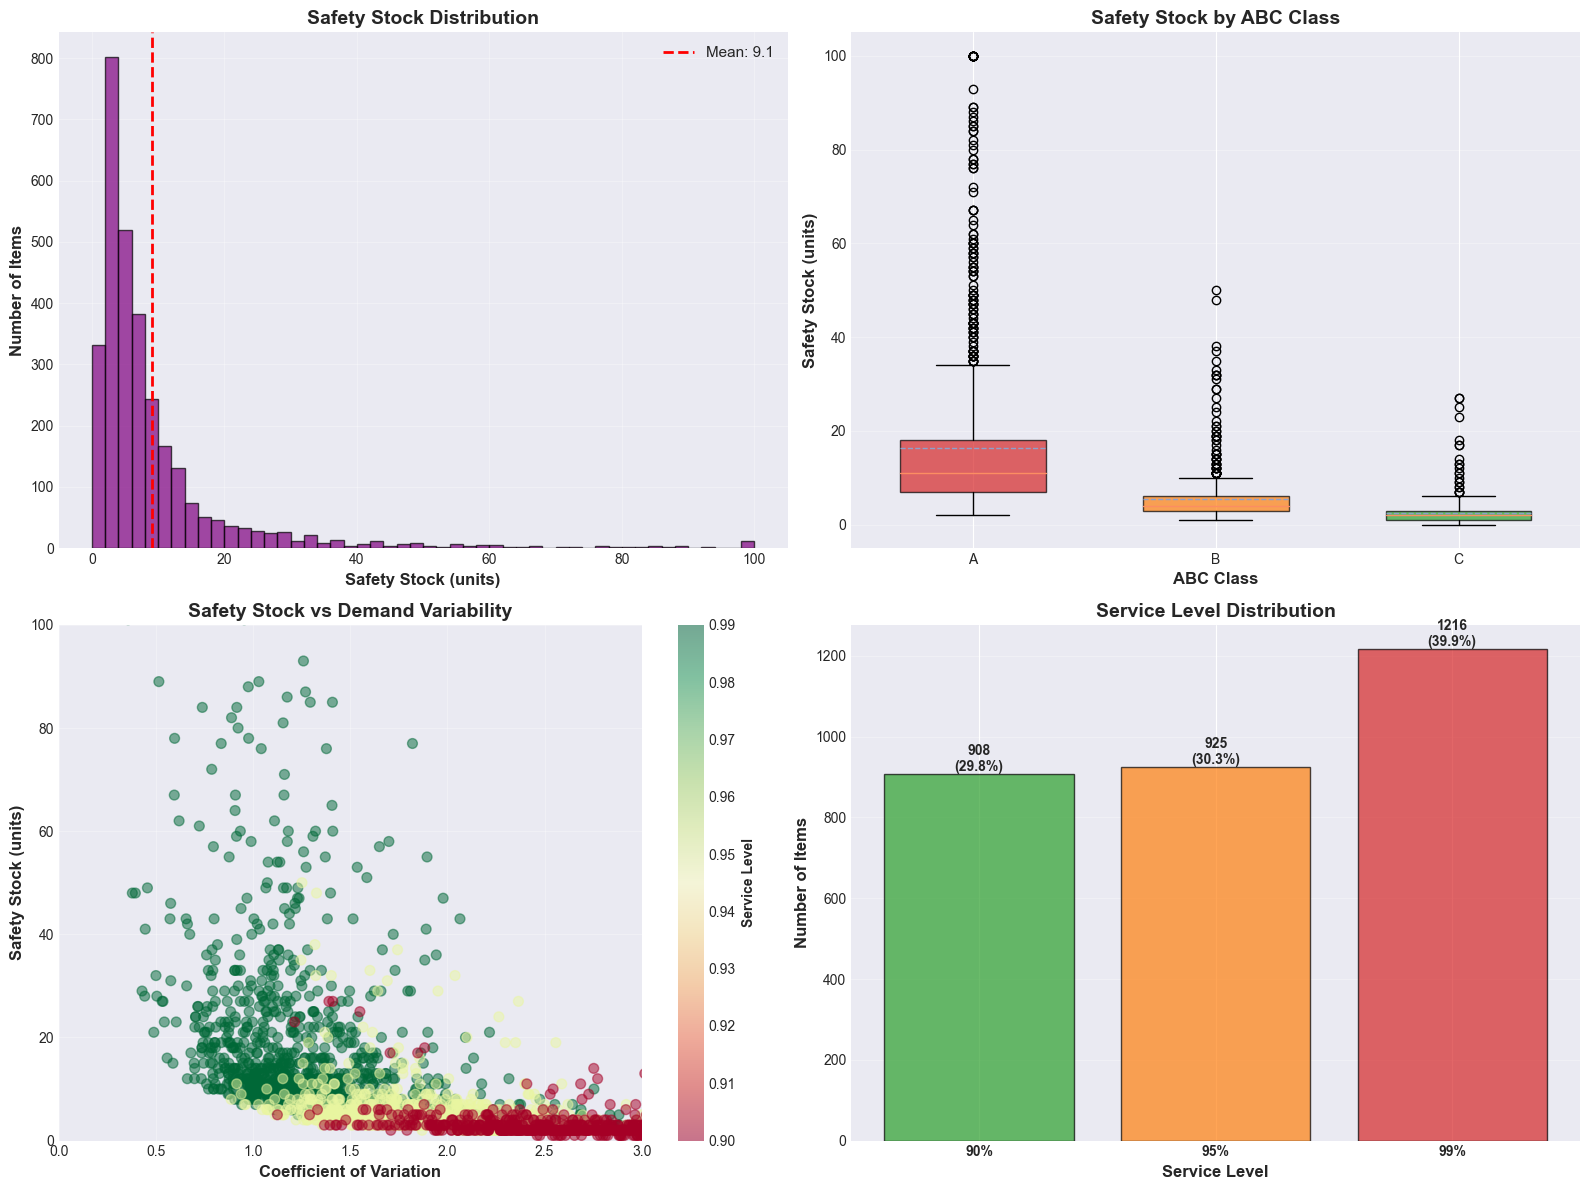

In [13]:
# Safety stock visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Safety stock distribution
axes[0, 0].hist(safety_results['safety_stock'].clip(0, 100), bins=50, alpha=0.7,
               color='purple', edgecolor='black')
axes[0, 0].axvline(x=safety_results['safety_stock'].mean(), color='red', linestyle='--',
                  linewidth=2, label=f"Mean: {safety_results['safety_stock'].mean():.1f}")
axes[0, 0].set_xlabel('Safety Stock (units)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Items', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Safety Stock Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Safety stock by ABC class
box_data_abc_ss = [safety_results[safety_results['abc_class'] == cls]['safety_stock'].clip(0, 100)
                   for cls in abc_order]
bp2 = axes[0, 1].boxplot(box_data_abc_ss, labels=abc_order, patch_artist=True,
                         widths=0.6, showmeans=True, meanline=True)
for patch, color in zip(bp2['boxes'], [colors_abc[c] for c in abc_order]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0, 1].set_xlabel('ABC Class', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Safety Stock (units)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Safety Stock by ABC Class', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Safety stock vs demand variability
axes[1, 0].scatter(safety_results['demand_cv'], safety_results['safety_stock'],
                  alpha=0.5, s=50, c=safety_results['service_level'], cmap='RdYlGn')
axes[1, 0].set_xlabel('Coefficient of Variation', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Safety Stock (units)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Safety Stock vs Demand Variability', fontsize=14, fontweight='bold')
axes[1, 0].set_xlim([0, 3])
axes[1, 0].set_ylim([0, 100])
axes[1, 0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(axes[1, 0].collections[0], ax=axes[1, 0])
cbar1.set_label('Service Level', fontsize=10, fontweight='bold')

# Service level distribution
service_counts = safety_results['service_level'].value_counts().sort_index()
axes[1, 1].bar(range(len(service_counts)), service_counts.values, 
              color=['#2ca02c', '#ff7f0e', '#d62728'], alpha=0.7, edgecolor='black')
axes[1, 1].set_xticks(range(len(service_counts)))
axes[1, 1].set_xticklabels([f"{x*100:.0f}%" for x in service_counts.index], fontweight='bold')
axes[1, 1].set_xlabel('Service Level', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Number of Items', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Service Level Distribution', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

for i, (val, count) in enumerate(zip(service_counts.index, service_counts.values)):
    axes[1, 1].text(i, count, f'{count}\n({count/len(safety_results)*100:.1f}%)',
                   ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

## 4. Reorder Point (ROP)

In [14]:
# Calculate reorder points
# ROP = Lead time demand + Safety stock
safety_results['lead_time_demand'] = (safety_results['sales_mean'] * lead_time).round(0).astype(int)
safety_results['reorder_point'] = (safety_results['lead_time_demand'] + safety_results['safety_stock']).astype(int)

final_results = safety_results.copy()

print(f"Reorder points calculated for {len(final_results)} items")
print(f"\nROP Statistics:")
print(f"  Mean: {final_results['reorder_point'].mean():.2f} units")
print(f"  Median: {final_results['reorder_point'].median():.2f} units")
print(f"  Range: {final_results['reorder_point'].min():.0f} - {final_results['reorder_point'].max():.0f} units")

final_results[['item_id', 'abc_class', 'eoq', 'safety_stock', 'lead_time_demand', 
               'reorder_point', 'service_level']].head(15)

Reorder points calculated for 3049 items

ROP Statistics:
  Mean: 18.33 units
  Median: 9.00 units
  Range: 0 - 819 units


,item_id,abc_class,eoq,safety_stock,lead_time_demand,reorder_point,service_level
2344,FOODS_3_120,A,11496,206,228,434,0.99
2314,FOODS_3_090,A,31109,354,465,819,0.99
2810,FOODS_3_586,A,24095,101,320,421,0.99
2426,FOODS_3_202,A,8759,62,115,177,0.99
2811,FOODS_3_587,A,14612,131,189,320,0.99
2023,FOODS_2_197,A,11546,78,149,227,0.99
2070,FOODS_2_244,A,6007,42,73,115,0.99
2476,FOODS_3_252,A,22840,115,274,389,0.99
1846,FOODS_2_019,A,10735,67,129,196,0.99
228,HOBBIES_1_236,A,2652,27,29,56,0.99


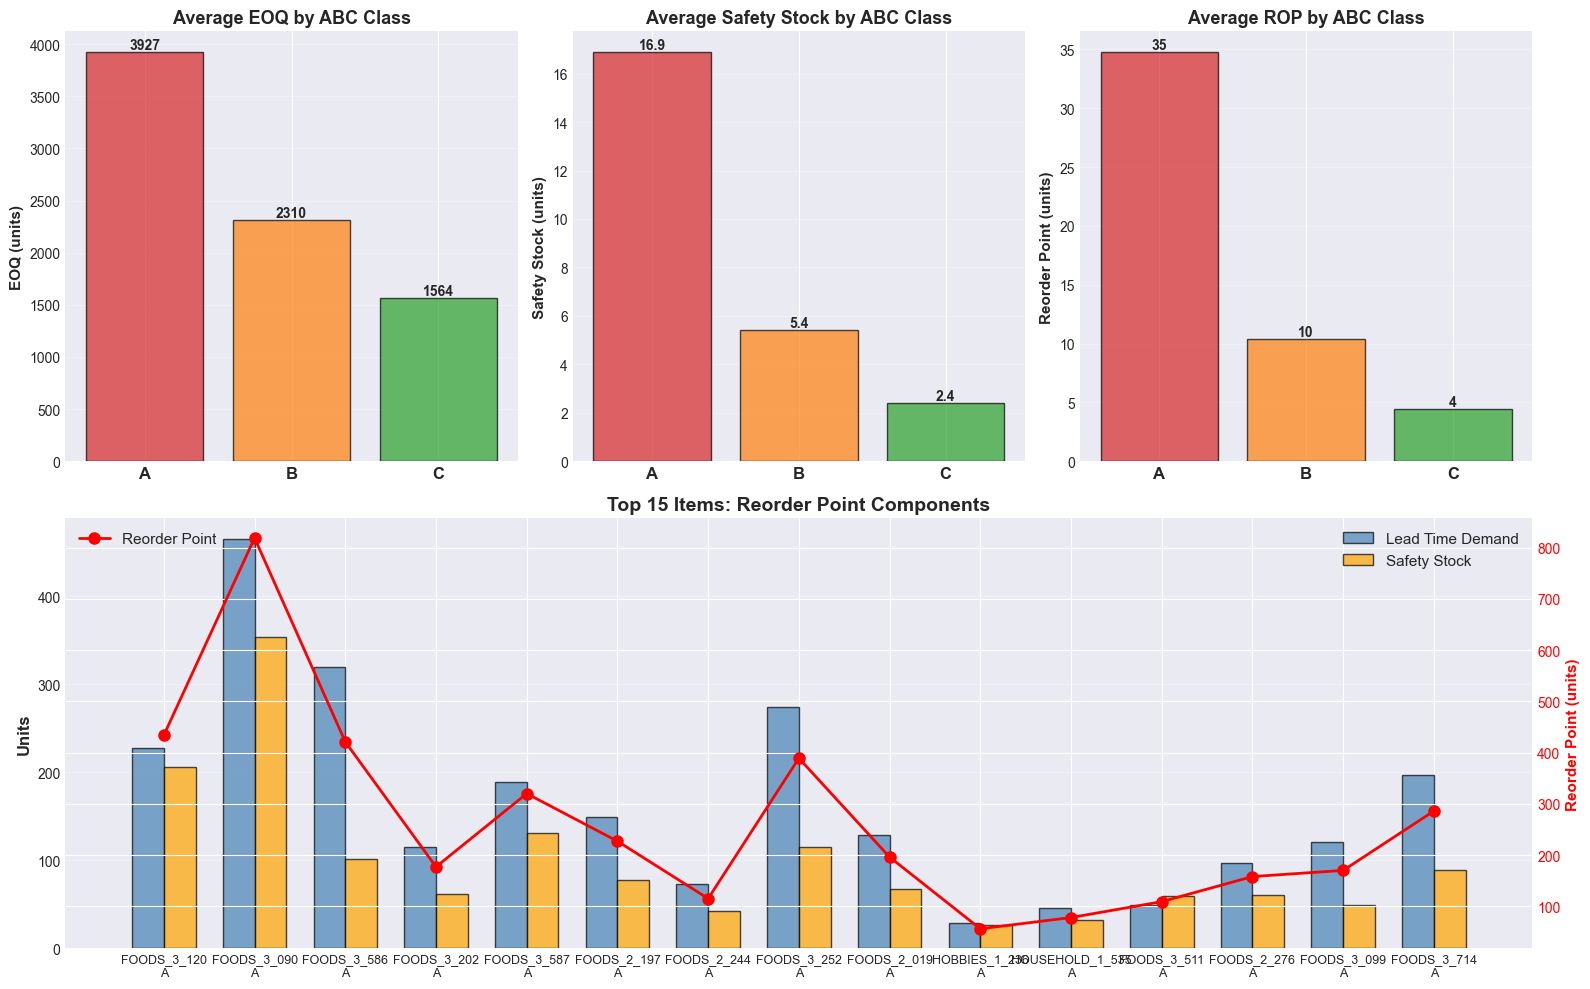

In [15]:
# Comprehensive inventory parameters
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 3, figure=fig)

# EOQ by ABC
ax1 = fig.add_subplot(gs[0, 0])
abc_stats = final_results.groupby('abc_class').agg({
    'eoq': 'mean',
    'safety_stock': 'mean',
    'reorder_point': 'mean'
}).round(1)
x = np.arange(len(abc_stats))
bars1 = ax1.bar(x, abc_stats['eoq'], color=[colors_abc[c] for c in abc_stats.index],
               alpha=0.7, edgecolor='black')
ax1.set_xticks(x)
ax1.set_xticklabels(abc_stats.index, fontweight='bold', fontsize=12)
ax1.set_ylabel('EOQ (units)', fontsize=11, fontweight='bold')
ax1.set_title('Average EOQ by ABC Class', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars1, abc_stats['eoq']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            f'{val:.0f}', ha='center', va='bottom', fontweight='bold')

# Safety Stock by ABC
ax2 = fig.add_subplot(gs[0, 1])
bars2 = ax2.bar(x, abc_stats['safety_stock'], color=[colors_abc[c] for c in abc_stats.index],
               alpha=0.7, edgecolor='black')
ax2.set_xticks(x)
ax2.set_xticklabels(abc_stats.index, fontweight='bold', fontsize=12)
ax2.set_ylabel('Safety Stock (units)', fontsize=11, fontweight='bold')
ax2.set_title('Average Safety Stock by ABC Class', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars2, abc_stats['safety_stock']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            f'{val:.1f}', ha='center', va='bottom', fontweight='bold')

# ROP by ABC
ax3 = fig.add_subplot(gs[0, 2])
bars3 = ax3.bar(x, abc_stats['reorder_point'], color=[colors_abc[c] for c in abc_stats.index],
               alpha=0.7, edgecolor='black')
ax3.set_xticks(x)
ax3.set_xticklabels(abc_stats.index, fontweight='bold', fontsize=12)
ax3.set_ylabel('Reorder Point (units)', fontsize=11, fontweight='bold')
ax3.set_title('Average ROP by ABC Class', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars3, abc_stats['reorder_point']):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            f'{val:.0f}', ha='center', va='bottom', fontweight='bold')

# Inventory components for top 15 items
ax4 = fig.add_subplot(gs[1, :])
top_15 = final_results.nlargest(15, 'revenue_sum')
x_pos = np.arange(len(top_15))
width = 0.35

bars_lt = ax4.bar(x_pos - width/2, top_15['lead_time_demand'], width,
                 label='Lead Time Demand', color='steelblue', alpha=0.7, edgecolor='black')
bars_ss = ax4.bar(x_pos + width/2, top_15['safety_stock'], width,
                 label='Safety Stock', color='orange', alpha=0.7, edgecolor='black')

ax4.set_xticks(x_pos)
ax4.set_xticklabels([f"{item}\n{cls}" for item, cls in zip(top_15['item_id'], top_15['abc_class'])],
                   rotation=0, fontsize=9, ha='center')
ax4.set_ylabel('Units', fontsize=12, fontweight='bold')
ax4.set_title('Top 15 Items: Reorder Point Components', fontsize=14, fontweight='bold')
ax4.legend(fontsize=11, loc='upper right')
ax4.grid(True, alpha=0.3, axis='y')

# Add ROP line
ax4_twin = ax4.twinx()
rop_line = ax4_twin.plot(x_pos, top_15['reorder_point'], 'ro-', linewidth=2, 
                         markersize=8, label='Reorder Point')
ax4_twin.set_ylabel('Reorder Point (units)', fontsize=11, fontweight='bold', color='red')
ax4_twin.tick_params(axis='y', labelcolor='red')
ax4_twin.legend(fontsize=11, loc='upper left')

plt.tight_layout()
plt.show()

## 5. Cost Analysis

In [16]:
# Calculate total inventory costs
holding_rate = config['inventory']['costs']['holding_cost_rate']
ordering_cost = config['inventory']['costs']['ordering_cost']

final_results['holding_cost'] = (final_results['eoq'] / 2 + final_results['safety_stock']) * \
                                final_results['avg_price'] * holding_rate
final_results['ordering_cost_annual'] = final_results['orders_per_year'] * ordering_cost
final_results['total_inventory_cost'] = final_results['holding_cost'] + final_results['ordering_cost_annual']

# Aggregate costs
total_holding = final_results['holding_cost'].sum()
total_ordering = final_results['ordering_cost_annual'].sum()
total_cost = final_results['total_inventory_cost'].sum()

print("=" * 80)
print("TOTAL INVENTORY COSTS")
print("=" * 80)
print(f"Total Holding Cost:   ${total_holding:>15,.2f} ({total_holding/total_cost*100:.1f}%)")
print(f"Total Ordering Cost:  ${total_ordering:>15,.2f} ({total_ordering/total_cost*100:.1f}%)")
print(f"Total Inventory Cost: ${total_cost:>15,.2f}")
print("=" * 80)

# Costs by ABC class
print("\nCosts by ABC Class:")
abc_costs = final_results.groupby('abc_class').agg({
    'holding_cost': 'sum',
    'ordering_cost_annual': 'sum',
    'total_inventory_cost': 'sum'
}).round(2)
abc_costs['pct_of_total'] = (abc_costs['total_inventory_cost'] / total_cost * 100).round(1)
abc_costs

TOTAL INVENTORY COSTS
Total Holding Cost:   $   2,902,999.65 (50.2%)
Total Ordering Cost:  $   2,880,648.45 (49.8%)
Total Inventory Cost: $   5,783,648.10

Costs by ABC Class:


,holding_cost,ordering_cost_annual,total_inventory_cost,pct_of_total
abc_class,,,,
A,1784344.03,1767145.73,3551489.76,61.4
B,721142.83,717401.08,1438543.91,24.9
C,397512.79,396101.64,793614.43,13.7


In [ ]:
# Cost breakdown visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Overall cost pie chart
cost_data = [total_holding, total_ordering]
cost_labels = ['Holding Cost', 'Ordering Cost']
colors_cost = ['#ff9999', '#66b3ff']
wedges, texts, autotexts = axes[0].pie(cost_data, labels=cost_labels, autopct='%1.1f%%',
                                       colors=colors_cost, startangle=90,
                                       textprops={'fontsize': 12, 'fontweight': 'bold'})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
axes[0].set_title('Overall Cost Breakdown', fontsize=14, fontweight='bold')

# Cost by ABC class
x = np.arange(len(abc_costs))
width = 0.35
bars_h = axes[1].bar(x - width/2, abc_costs['holding_cost'], width, label='Holding',
                    color='#ff9999', alpha=0.7, edgecolor='black')
bars_o = axes[1].bar(x + width/2, abc_costs['ordering_cost_annual'], width, label='Ordering',
                    color='#66b3ff', alpha=0.7, edgecolor='black')
axes[1].set_xticks(x)
axes[1].set_xticklabels(abc_costs.index, fontweight='bold', fontsize=12)
axes[1].set_ylabel('Cost ($)', fontsize=12, fontweight='bold')
axes[1].set_title('Inventory Costs by ABC Class', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

# Cost distribution by ABC
abc_pct = abc_costs['pct_of_total']
bars_pct = axes[2].bar(x, abc_pct, color=[colors_abc[c] for c in abc_costs.index],
                      alpha=0.7, edgecolor='black')
axes[2].set_xticks(x)
axes[2].set_xticklabels(abc_costs.index, fontweight='bold', fontsize=12)
axes[2].set_ylabel('% of Total Cost', fontsize=12, fontweight='bold')
axes[2].set_title('Cost Distribution by ABC Class', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars_pct, abc_pct):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

## 6. Service Level Trade-off Analysis

In [ ]:
# Sensitivity analysis for service levels
service_level_range = np.arange(0.80, 0.99, 0.01)
z_scores = stats.norm.ppf(service_level_range)

# Calculate safety stock and costs for different service levels
sample_item = final_results.nlargest(1, 'revenue_sum').iloc[0]
demand_std = sample_item['sales_std']
lead_time = config['inventory']['lead_time']['default']
price = sample_item['avg_price']

safety_stocks = z_scores * demand_std * np.sqrt(lead_time)
holding_costs = safety_stocks * price * holding_rate

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Safety stock vs service level
ax1.plot(service_level_range * 100, safety_stocks, 'b-', linewidth=2)
ax1.axhline(y=sample_item['safety_stock'], color='red', linestyle='--', linewidth=2,
           label=f"Current: {sample_item['service_level']*100:.0f}% SL")
ax1.axvline(x=sample_item['service_level']*100, color='red', linestyle='--', linewidth=2)
ax1.fill_between(service_level_range * 100, 0, safety_stocks, alpha=0.2)
ax1.set_xlabel('Service Level (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Safety Stock (units)', fontsize=12, fontweight='bold')
ax1.set_title(f'Safety Stock vs Service Level\n(Item: {sample_item["item_id"]})', 
             fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Incremental cost vs service level
cost_increase = holding_costs - holding_costs[0]
ax2.plot(service_level_range * 100, cost_increase, 'g-', linewidth=2)
ax2.axvline(x=sample_item['service_level']*100, color='red', linestyle='--', linewidth=2,
           label=f"Current: {sample_item['service_level']*100:.0f}% SL")
ax2.fill_between(service_level_range * 100, 0, cost_increase, alpha=0.2, color='green')
ax2.set_xlabel('Service Level (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Additional Holding Cost ($)', fontsize=12, fontweight='bold')
ax2.set_title(f'Incremental Cost vs Service Level\n(Baseline: 80% SL)', 
             fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFor {sample_item['item_id']} ({sample_item['abc_class']} class):")
print(f"  Moving from 90% to 95% SL increases safety stock by "
      f"{(safety_stocks[10] - safety_stocks[5]):.1f} units")
print(f"  Moving from 95% to 99% SL increases safety stock by "
      f"{(safety_stocks[-1] - safety_stocks[15]):.1f} units")

## 7. Recommendations and Action Items

In [ ]:
# Generate top recommendations
print("=" * 90)
print("TOP 20 ITEMS REQUIRING IMMEDIATE ACTION")
print("=" * 90)
print()

action_items = final_results.nlargest(20, 'revenue_sum')[[
    'item_id', 'cat_id', 'abc_xyz_class', 'eoq', 'safety_stock', 
    'reorder_point', 'service_level', 'total_inventory_cost'
]].copy()

action_items['eoq'] = action_items['eoq'].round(0).astype(int)
action_items['safety_stock'] = action_items['safety_stock'].round(0).astype(int)
action_items['reorder_point'] = action_items['reorder_point'].round(0).astype(int)
action_items['service_level'] = (action_items['service_level'] * 100).round(0).astype(int)
action_items['total_inventory_cost'] = action_items['total_inventory_cost'].round(2)

action_items.rename(columns={
    'item_id': 'Item',
    'cat_id': 'Category',
    'abc_xyz_class': 'Class',
    'eoq': 'EOQ',
    'safety_stock': 'SS',
    'reorder_point': 'ROP',
    'service_level': 'SL%',
    'total_inventory_cost': 'Cost$'
}, inplace=True)

action_items

In [ ]:
# Summary insights
print("=" * 90)
print("KEY INSIGHTS AND RECOMMENDATIONS")
print("=" * 90)
print()

print("📊 INVENTORY OPTIMIZATION RESULTS:")
print(f"  • Total items analyzed: {len(final_results):,}")
print(f"  • Average EOQ: {final_results['eoq'].mean():.0f} units")
print(f"  • Average Safety Stock: {final_results['safety_stock'].mean():.1f} units")
print(f"  • Average Reorder Point: {final_results['reorder_point'].mean():.0f} units")
print(f"  • Average orders per year: {final_results['orders_per_year'].mean():.1f}")
print()

print("💰 COST ANALYSIS:")
print(f"  • Total Inventory Cost: ${total_cost:,.2f}")
print(f"  • Holding Cost: ${total_holding:,.2f} ({total_holding/total_cost*100:.1f}%)")
print(f"  • Ordering Cost: ${total_ordering:,.2f} ({total_ordering/total_cost*100:.1f}%)")
print(f"  • Class A contributes {abc_costs.loc['A', 'pct_of_total']:.1f}% of total costs")
print()

print("🎯 ACTION ITEMS:")
print("  1. Implement differentiated service levels (A: 99%, B: 97%, C: 95%)")
print("  2. Set up automated reorder alerts at calculated ROPs")
print("  3. Order EOQ quantities to minimize total costs")
print("  4. Monitor high-variability (Z-class) items closely")
print("  5. Review and adjust safety stock quarterly")
print()

print("📈 EXPECTED BENEFITS:")
print("  • Reduced stockouts through optimal safety stock")
print("  • Lower holding costs via EOQ ordering")
print("  • Improved service levels for critical items")
print("  • Better cash flow through reduced inventory")
print("  • Automated replenishment process")
print()
print("=" * 90)

## 8. Save Final Results

In [ ]:
# Save complete optimization results
output_path = project_root / 'data/processed'
final_results.to_csv(output_path / 'inventory_optimization_complete_ca1.csv', index=False)

# Save top recommendations
action_items.to_csv(output_path / 'top_20_recommendations_ca1.csv', index=False)

print("✅ Optimization complete!")
print(f"✅ Results saved to {output_path}")
print(f"   - inventory_optimization_complete_ca1.csv ({len(final_results)} items)")
print(f"   - top_20_recommendations_ca1.csv (20 items)")

## 🎉 Analysis Complete!

This notebook has provided:
1. ✅ Economic Order Quantities (EOQ)
2. ✅ Safety Stock calculations
3. ✅ Reorder Points (ROP)
4. ✅ Cost analysis and optimization
5. ✅ Service level trade-offs
6. ✅ Actionable recommendations

**Next Steps:**
- Implement recommended parameters in inventory system
- Set up automated alerts for reorder points
- Monitor actual vs. predicted performance
- Adjust parameters quarterly based on actual data